### Use Spark NLP for Text Classification

* Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages.

* The library is built on top of Apache Spark and its Spark ML library.


* We will learn how to use Spark NLP for text preprocessing and build machine learning models to classify text into different categories.

In [ ]:
#Install Java Development kit for Spark
!apt-get install openjdk-8-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libice-dev librsvg2-common
  libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs libice-doc libsm-doc libxt-doc openjdk-8-demo openjdk-8-source visualvm libnss-mdns
  fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei
  fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java libatk-wrapper-java-jni libfontenc1
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libice-dev librsvg2-common
  libsm-dev libxkbfile1 libxt-dev libxtst6 libxxf86dga1 openjdk-

In [ ]:
import os
#Set the JAVA_HOME env variable
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
#Current working directory
!pwd

/content


In [ ]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [ ]:
#Install PySpark with latest version
!pip install --upgrade PySpark

In [ ]:
!pip install --upgrade cloudpickle

  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.0
    Uninstalling cloudpickle-3.1.0:
      Successfully uninstalled cloudpickle-3.1.0


In [ ]:
# Install Spark NLP
!pip install spark-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.3/636.3 kB 25.3 MB/s eta 0:00:00


In [ ]:
# Import modules
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import functions as fun
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *

## BBC News Summary Dataset

Sources: https://www.kaggle.com/datasets/pariza/bbc-news-summary; http://mlg.ucd.ie/datasets/bbc.html

\
The dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. There are five class Labels: business, entertainment, politics, sport, and tech.

\
Dataset structure:

\
* News Articles
  * business (txt files, e.g., 001.txt)
  * entertainment (txt files)
  * politics (txt files)
  * sport (txt files)
  * tech (txt files)

\
* Summaries
  * business (txt files, e.g., 001.txt)
  * entertainment (txt files)
  * politics (txt files)
  * sport (txt files)
  * tech (txt files)

In [ ]:
#mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = '/content/drive/My Drive/BBC News Summary/'

Construct dataframe in the following form <br><br> <b>news_text | news_topic </b> <br><br> news_text is the data from the text file. SparkNLP needs full path of the file in order to read the text data from the file.<br> e.g. '/content/drive/My Drive/BBC News Summary/Summaries/entertainment/005.txt' <br><br> news_topic can fetched from the parent folder of the text file


In [ ]:
import os
for path, subdirs, files in os.walk(root):
  print(path)

/content/drive/My Drive/BBC News Summary/
/content/drive/My Drive/BBC News Summary/entertainment
/content/drive/My Drive/BBC News Summary/sport
/content/drive/My Drive/BBC News Summary/politics
/content/drive/My Drive/BBC News Summary/tech
/content/drive/My Drive/BBC News Summary/business


In [ ]:
import os
for path, subdirs, files in os.walk(root):
  for name in subdirs:
    print(name)

entertainment
sport
politics
tech
business


In [ ]:
import os
for path, subdirs, files in os.walk(root):
  for name in files:
    print(name)

005.txt
001.txt
004.txt
002.txt
003.txt
028.txt
030.txt
024.txt
017.txt
012.txt
025.txt
021.txt
011.txt
013.txt
032.txt
016.txt
007.txt
020.txt
033.txt
029.txt
019.txt
022.txt
018.txt
008.txt
036.txt
014.txt
009.txt
023.txt
034.txt
006.txt
039.txt
010.txt
015.txt
026.txt
035.txt
027.txt
037.txt
031.txt
038.txt
040.txt
070.txt
057.txt
054.txt
043.txt
060.txt
051.txt
073.txt
068.txt
050.txt
061.txt
071.txt
055.txt
065.txt
042.txt
041.txt
063.txt
046.txt
052.txt
072.txt
048.txt
074.txt
053.txt
059.txt
049.txt
047.txt
069.txt
066.txt
044.txt
058.txt
067.txt
045.txt
062.txt
056.txt
064.txt
089.txt
094.txt
081.txt
101.txt
102.txt
082.txt
096.txt
079.txt
093.txt
075.txt
098.txt
108.txt
104.txt
099.txt
110.txt
090.txt
077.txt
095.txt
106.txt
086.txt
080.txt
097.txt
109.txt
085.txt
087.txt
103.txt
084.txt
100.txt
076.txt
088.txt
078.txt
107.txt
105.txt
091.txt
092.txt
083.txt
112.txt
145.txt
117.txt
118.txt
134.txt
116.txt
125.txt
115.txt
129.txt
119.txt
142.txt
130.txt
136.txt
141.txt
122.txt


In [ ]:
# In Spark NLP, wholeTextFile() will return an error when it finds a nested folder.
# Therefore, we need to create a file path list by traversing all nested folders

lst_filenames = [os.path.join(path, name) for path, subdirs, files in os.walk(root) for name in files]
print(len(lst_filenames))
lst_filenames[:5]

2225


['/content/drive/My Drive/BBC News Summary/entertainment/005.txt',
 '/content/drive/My Drive/BBC News Summary/entertainment/001.txt',
 '/content/drive/My Drive/BBC News Summary/entertainment/004.txt',
 '/content/drive/My Drive/BBC News Summary/entertainment/002.txt',
 '/content/drive/My Drive/BBC News Summary/entertainment/003.txt']

In [ ]:
# Start the Spark NLP session
spark = sparknlp.start()

In [ ]:
"""
The code reads all the text files specified in the lst_filenames list using Spark NLP's wholeTextFiles() method.
It returns data containing pairs of filenames and their corresponding content.
This data can then be further processed or analyzed using Spark's distributed computing capabilities.
"""
texts = spark.sparkContext.wholeTextFiles(','.join(lst_filenames))
# texts -> key-value pairs, where the keys are file paths and the values are the contents of the corresponding files as strings

In [ ]:
# Create a schema for the imported files
bbc_data_schema = StructType([
  StructField('filename', StringType()),
  StructField('text', StringType())
])

In [ ]:
# Create a Spark NLP dataframe
texts = spark.createDataFrame(texts, schema = bbc_data_schema)
texts.show()

+--------------------+--------------------+
|            filename|                text|
+--------------------+--------------------+
|file:/content/dri...|Mary Poppins was ...|
|file:/content/dri...|The messages will...|
|file:/content/dri...|"It was very hard...|
|file:/content/dri...|Bloom is to be fo...|
|file:/content/dri...|The classic film ...|
|file:/content/dri...|His first film fo...|
|file:/content/dri...|The Chicago Film ...|
|file:/content/dri...|A novel set in 19...|
|file:/content/dri...|Dame Muriel Spark...|
|file:/content/dri...|The Ballymena-bor...|
|file:/content/dri...|"The fact that th...|
|file:/content/dri...|She became direct...|
|file:/content/dri...|Ms Bradburn said ...|
|file:/content/dri...|Orange Prize winn...|
|file:/content/dri...|Redford wanted Su...|
|file:/content/dri...|The writer was kn...|
|file:/content/dri...|The five writers ...|
|file:/content/dri...|It was bought by ...|
|file:/content/dri...|This third Harry ...|
|file:/content/dri...|A film bas

In [ ]:
# We can convert the Spark NLP dataframe to Pandas dataframe
texts.limit(5).toPandas()

filename  \
0  file:/content/drive/My Drive/BBC News Summary/...   
1  file:/content/drive/My Drive/BBC News Summary/...   
2  file:/content/drive/My Drive/BBC News Summary/...   
3  file:/content/drive/My Drive/BBC News Summary/...   
4  file:/content/drive/My Drive/BBC News Summary/...   

                                                text  
0  Mary Poppins was originally created by author ...  
1  The messages will be "unwrapped" by sculptor R...  
2  "It was very hard to follow last year's extrem...  
3  Bloom is to be formally presented with the Han...  
4  The classic film It's A Wonderful Life is to b...

In [ ]:
type(texts)

pyspark.sql.dataframe.DataFrame

In [ ]:
texts.limit(5).toPandas()['filename'][0]

'file:/content/drive/My Drive/BBC News Summary/entertainment/005.txt'

In [ ]:
texts.limit(5).toPandas()['text'][0]

"Mary Poppins was originally created by author Pamela Travers, who is said to have cried when she saw Disney's 1964 film starring Julie Andrews.The stage adaptation of children's film Mary Poppins has had its opening night in London's West End.Sir Cameron Mackintosh's lavish production, which has cost £9m to bring to the stage, was given a 10-minute standing ovation.Theatre impresario Sir Cameron Mackintosh has said he hopes the musical is a blend of the sweet-natured film and the original book."

In [ ]:
# Create a new column that stores the article topics for the text summarries
# Note: getItem will get the item by its index, which starts from 0
texts = texts.withColumn(
  'topic',
  fun.split('filename', '/').getItem(5)
  )

In [ ]:
 # Take a look at the newly created label column
texts.limit(5).toPandas()

filename  \
0  file:/content/drive/My Drive/BBC News Summary/...   
1  file:/content/drive/My Drive/BBC News Summary/...   
2  file:/content/drive/My Drive/BBC News Summary/...   
3  file:/content/drive/My Drive/BBC News Summary/...   
4  file:/content/drive/My Drive/BBC News Summary/...   

                                                text          topic  
0  Mary Poppins was originally created by author ...  entertainment  
1  The messages will be "unwrapped" by sculptor R...  entertainment  
2  "It was very hard to follow last year's extrem...  entertainment  
3  Bloom is to be formally presented with the Han...  entertainment  
4  The classic film It's A Wonderful Life is to b...  entertainment

([<matplotlib.axis.XTick at 0x7f1967b9d690>,
 [Text(0, 0, 'politics'),
  Text(0, 0, 'entertainment'),
  Text(0, 0, 'business'),
  Text(0, 0, 'sport'),
  Text(0, 0, 'tech')])

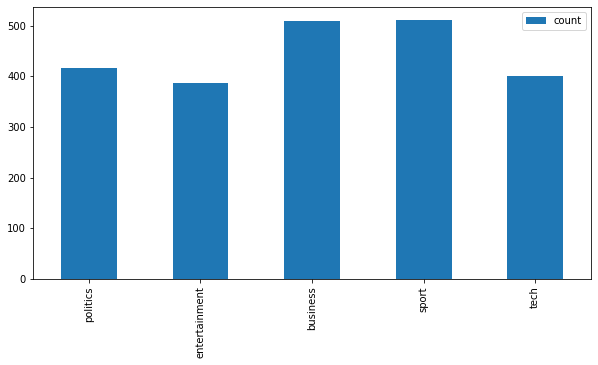

In [ ]:
# Take a look at the number of documents pertaining to each label
label_counts = texts.groupBy('topic').count().toPandas()
label_counts.plot(kind = 'bar', figsize = (10, 5))
plt.xticks(
  ticks = range(len(label_counts)),
  labels = label_counts['topic']
 )

In [ ]:
# Take a look at the schema of the Spark NLP dataframe
texts.printSchema()

root
 |-- filename: string (nullable = true)
 |-- text: string (nullable = true)
 |-- topic: string (nullable = true)



In [ ]:
# Randomly split the Spark NLP dataframe into train and test sets
train, test = texts.randomSplit([0.8, 0.2], seed = 123)

In [ ]:
# Define the assembler
"""
To process raw text in Spark NLP, we need to get raw data transformed into Document type at first.
DocumentAssembler() is a special transformer that does this for us that can be fed into subsequent pipeline components,
such as tokenizer, lemmatizer etc.

This representation typically includes metadata such as document ID, language, and the raw text content itself.
"""
assembler = DocumentAssembler()\
  .setInputCol('text')\
  .setOutputCol('document')
docs = assembler.transform(texts)
docs.limit(5).toPandas()

filename  \
0  file:/content/drive/My Drive/BBC News Summary/...   
1  file:/content/drive/My Drive/BBC News Summary/...   
2  file:/content/drive/My Drive/BBC News Summary/...   
3  file:/content/drive/My Drive/BBC News Summary/...   
4  file:/content/drive/My Drive/BBC News Summary/...   

                                                text          topic  \
0  Mary Poppins was originally created by author ...  entertainment   
1  The messages will be "unwrapped" by sculptor R...  entertainment   
2  "It was very hard to follow last year's extrem...  entertainment   
3  Bloom is to be formally presented with the Han...  entertainment   
4  The classic film It's A Wonderful Life is to b...  entertainment   

                                            document  
0  [(document, 0, 498, Mary Poppins was originall...  
1  [(document, 0, 553, The messages will be "unwr...  
2  [(document, 0, 660, "It was very hard to follo...  
3  [(document, 0, 667, Bloom is to be formally pr...  
4  [(document, 0, 475, The classic film It's A Wo...

In [ ]:
docs.limit(5).toPandas()['document'][0]

[Row(annotatorType='document', begin=0, end=498, result="Mary Poppins was originally created by author Pamela Travers, who is said to have cried when she saw Disney's 1964 film starring Julie Andrews.The stage adaptation of children's film Mary Poppins has had its opening night in London's West End.Sir Cameron Mackintosh's lavish production, which has cost £9m to bring to the stage, was given a 10-minute standing ovation.Theatre impresario Sir Cameron Mackintosh has said he hopes the musical is a blend of the sweet-natured film and the original book.", metadata={'sentence': '0'}, embeddings=[])]

In [ ]:
# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['document'])\
  .setOutputCol('tokens')


In [ ]:
# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
# Define the normalizer

#The Normalizer() function in Spark NLP is used to perform normalization of text data. Normalization typically involves converting text to a standard format
# or representation, such as converting all characters to lowercase, removing accents, or expanding contractions.
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

In [ ]:
# Define the finisher

"""
Finisher: Getting data out
At the end of each pipeline or any stage that was done by Spark NLP,
you may want to get results out whether onto another pipeline or simply
write them on disk.
"""
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

In [ ]:
# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))
print(stopwords)

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

{'here', "couldn't", 'a', 'too', 'have', "we'll", 'you', 'further', 'her', "you'll", 'being', 'just', 'themselves', "aren't", 'could', 'or', 'was', 'would', 'yours', 'by', 'no', 'who', "he'd", "you've", 'between', 'up', 'but', "how's", 'after', 'its', 'both', 'i', "he's", 'nor', "she'd", 'above', 'until', "don't", "doesn't", 'same', 'before', 'ours', 'himself', 'your', 'into', 'our', 'how', 'their', 'out', "they're", 'what', 'why', 'these', "hasn't", 'under', 'should', 'ourselves', 'only', 'been', 'me', 'when', "won't", "mustn't", 'ought', 'this', "i'd", 'yourselves', "we've", 'am', "it's", "wasn't", 'be', 'that', 'against', 'cannot', 'theirs', 'an', 'from', 'off', "weren't", "i've", "can't", "they'd", 'few', "we'd", 'does', 'which', 'did', 'if', 'we', 'very', "they'll", "you're", "let's", 'having', 'about', "he'll", "wouldn't", 'for', "why's", 'because', 'below', 'during', 'on', "i'll", 'those', 'with', "when's", 'while', 'has', 'there', "there's", "we're", 'it', 'them', "shan't", 'my

In [ ]:
# Define count vectorizer
#If minDF is set to an integer value k, then the term must appear in at least k documents to be considered in the vocabulary.
#Terms that appear in fewer than k documents will be ignored and not included in the vocabulary.
count_vectorizer = CountVectorizer(
  inputCol = 'filtered',
  outputCol = 'tf', minDF = 10
  )

In [ ]:
# Define TF-IDF
#minDocFreq specifies the minimum number of documents in which a term (word) must appear in order to be considered for IDF computation.
tfidf = IDF(
  inputCol = 'tf',
  outputCol = 'tfidf',
  minDocFreq = 10
  )

In [ ]:
# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,

    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer,
    tfidf
   ])

In [ ]:
# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'topic',
  outputCol = 'label').fit(texts)

In [ ]:
# Take a look at the indexed labels
label_indexer.labels

['sport', 'business', 'politics', 'tech', 'entertainment']

In [ ]:
# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction',
  outputCol = 'pred_label',
  labels = label_indexer.labels)

In [ ]:
# Define a model
naive_bayes = NaiveBayes(featuresCol = 'tfidf')

In [ ]:
# Define the overall pipeline
pipeline = Pipeline(
  stages = [
    text_processing_pipeline,
    label_indexer,
    naive_bayes,
    prediction_deindexer
  ])

In [ ]:
# Train the model
model = pipeline.fit(train)

In [ ]:
# Make predictions on the train and test sets
train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [ ]:
# Innitiate the ACCURACY score
evaluator = MulticlassClassificationEvaluator(metricName = 'accuracy')

In [ ]:
# Report the F1 score on the train set
print('accuracy on train set', evaluator.evaluate(train_predicted))

accuracy on train set 0.989391401451703


In [ ]:
# Report the F1 score on the test set
print('accuracy on test set', evaluator.evaluate(test_predicted))

accuracy on test set 0.9493087557603687


In [ ]:
# Define a function to try out different ML models
def fit_model(model):

  # Define the type of model
  model_type = model(featuresCol = 'tfidf')

  # Construct the overall pipeline
  pipeline = Pipeline(
  stages = [
    text_processing_pipeline,
    label_indexer,
    model_type,
    prediction_deindexer
  ])

  # Train the model
  model = pipeline.fit(train)

  # Make predictions on the train and test sets
  train_predicted = model.transform(train)
  test_predicted = model.transform(test)

  # Innitiate the F1 score
  evaluator = MulticlassClassificationEvaluator(metricName = 'accuracy')

  # Report the F1 score on the train set
  print(f'{str(model)}: accuracy on train set', evaluator.evaluate(train_predicted))

  # Report the F1 score on the test set
  print(f'{str(model)}: accuracy on test set', evaluator.evaluate(test_predicted))

In [ ]:
# Fit a logistic regression
fit_model(LogisticRegression)

PipelineModel_5ea0a38d4b01: accuracy on train set 1.0
PipelineModel_5ea0a38d4b01: accuracy on test set 0.9147465437788018


In [ ]:
# Fit a random forest classifier
fit_model(RandomForestClassifier)

PipelineModel_bbd5b9208695: f1 on train set 0.7941192580748638
PipelineModel_bbd5b9208695: f1 on test set 0.7214999913078831
